In [1]:
import trimesh
mesh = trimesh.load('datasets/dataset_snippet_medium_normalized/AircraftBuoyant/m1344.obj')

# Dataset Stats

              Class  obj_count
0               Jet        143
1          Humanoid        142
2               Car         89
3            Insect         66
4      PlantIndoors         65
..              ...        ...
64          Monitor         20
65            Wheel         17
66  AircraftBuoyant         16
67              Hat         15
68             Sign         15

[69 rows x 2 columns]


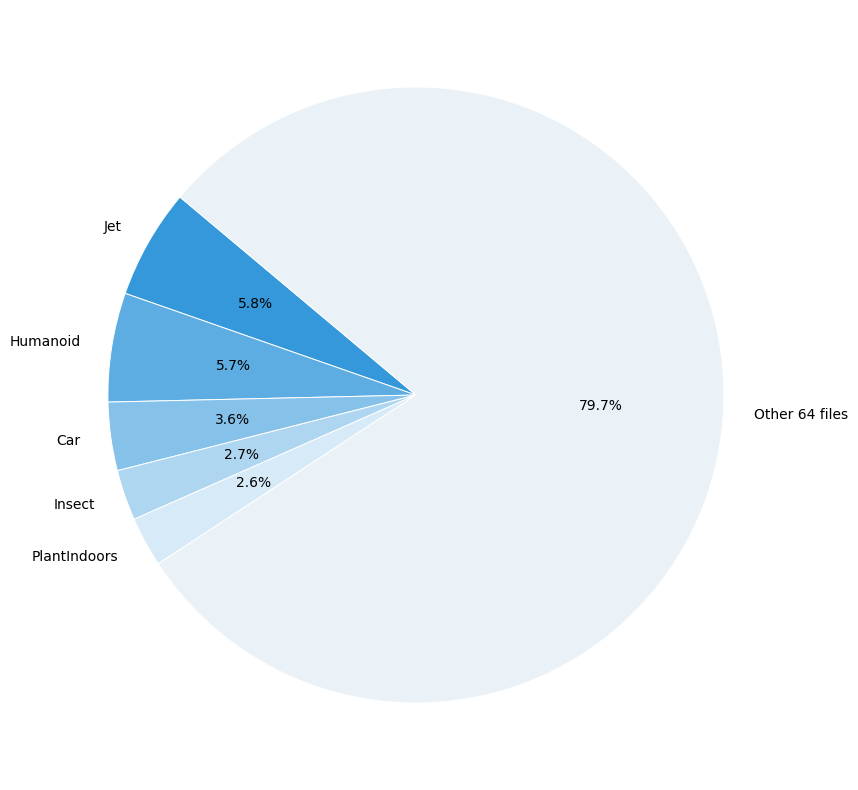

In [71]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the path to your "original_dataset" directory
base_path = 'datasets/dataset_original'

# Create a dictionary to store folder names and the count of .obj files
data = []

# Loop through each folder in the base path
for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    if os.path.isdir(folder_path):  # Check if it's a directory
        # Count the number of .obj files in the folder
        obj_files = [f for f in os.listdir(folder_path) if f.endswith('.obj')]
        data.append({"Class": folder_name, "obj_count": len(obj_files)})

# Convert the dictionary into a DataFrame with one row
df = pd.DataFrame(data).sort_values(by="obj_count", ascending=False).reset_index(drop=True)
df.to_csv("outputs/data/class_distribution.csv")
# Display the DataFrame
print(df)

# Separate the top 5 folders and the rest
top_5 = df.iloc[:5]
others = df.iloc[5:]

# Calculate the total count for "Others"
other_labels = len(df) - len(top_5)
other_objects = others["obj_count"].sum()

# Prepare data for the pie chart
pie_labels = top_5["Class"].tolist() + [f"Other {other_labels} files"]
pie_counts = top_5["obj_count"].tolist() + [other_objects]

colors = ['#3498DB','#5DADE2',  '#85C1E9', '#AED6F1', '#D6EAF8', '#EAF2F8']

# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(pie_counts, labels=pie_labels, autopct='%1.1f%%', startangle=140, colors=colors[:len(pie_labels)], wedgeprops = { 'linewidth' : 0.7, 'edgecolor' : 'white' })
plt.show()

# Save Histograms of Local Descriptors

In [ ]:
import os
import pandas as pd
import ast
import matplotlib.pyplot as plt


# Function to create a directory if it doesn't exist
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

def plot_metric_for_class(local_descriptors_df, class_name, metrics, save_dir, num_bins=30):
    """
    Create one plot for each metric (A3, D1, D2, D3, D4) for all objects in a class.
    Each plot will contain lines for all objects' histograms for that metric.
    """
    class_data = local_descriptors_df[local_descriptors_df['obj_class'] == class_name]
    
    # Directory to save the plots
    class_save_dir = os.path.join(save_dir, class_name)
    create_directory(class_save_dir)
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        
        for _, row in class_data.iterrows():
            file_name = row['file_name']
            data = row[metric]
            
            # Plot each object histogram
            plt.plot(data, label=file_name)

        # Set plot details
        plt.title(f"{metric} Histograms for Class {class_name}")
        plt.xlabel(f'Normalized {metric} range (0 to 1)')
        plt.ylabel('Frequency')
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True)
        
        # Calculate the number of bins (x-axis points)
        num_bins = len(data)
        # Create a list of normalized positions (0 to 1) for the x-axis ticks
        tick_positions = [int(num_bins * i / 5) for i in range(6)]
        tick_labels = [f'{i/5:.1f}' for i in range(6)]
        
        # Adjust x-ticks to show 0, 0.2, 0.4, 0.6, 0.8, 1
        plt.xticks(tick_positions, tick_labels)

        # Save the plot
        plt.savefig(os.path.join(class_save_dir, f"{metric}_plot.png"))
        plt.close()

    print(f"{class_name}", end=", ")
    


    

# Main function to loop through all classes and create the plots
def create_all_class_plots(local_descriptors_df, save_dir):
    """
    Loop through each class and create 5 plots (one for each metric: A3, D1, D2, D3, D4).
    Each plot will contain lines representing the histograms of all objects for that metric.
    """
    metrics = ['A3', 'D1', 'D2', 'D3', 'D4']  # List of metrics
    class_names = local_descriptors_df['obj_class'].unique()  # Get all unique classes
    
    # Create a folder for the plots
    create_directory(save_dir)

    print("All plots saved for", end=": ")
    for class_name in class_names:
        plot_metric_for_class(local_descriptors_df, class_name, metrics, save_dir)


# Load the CSV file
local_descriptors_df = pd.read_csv('outputs/data/local_descriptors.csv')

# Convert the string representations of lists back to actual lists
for col in ['A3', 'D1', 'D2', 'D3', 'D4']:
    local_descriptors_df[col] = local_descriptors_df[col].apply(lambda x: ast.literal_eval(x))



# Directory to save plots
main_save_dir = 'local_desc_plots'
create_directory(main_save_dir)

create_all_class_plots(local_descriptors_df, main_save_dir)


print("\nAll histograms saved successfully!")

All plots saved for: AircraftBuoyant, Apartment, AquaticAnimal, Bed, Bicycle, Biplane, Bird, Bookset, Bottle, BuildingNonResidential, Bus, Car, Cellphone, Chess, City, ClassicPiano, Computer, ComputerKeyboard, Cup, DeskLamp, DeskPhone, Door, Drum, Fish, FloorLamp, Glasses, Guitar, Gun, Hand, Hat, Helicopter, House, HumanHead, Humanoid, Insect, Jet, Knife, MilitaryVehicle, Monitor, Monoplane, Motorcycle, Mug, MultiSeat, Musical_Instrument, NonWheelChair, PianoBoard, PlantIndoors, PlantWildNonTree, Quadruped, RectangleTable, Rocket, RoundTable, Shelf, Ship, Sign, Skyscraper, Spoon, Starship, SubmachineGun, Sword, Tool, Train, Tree, Truck, TruckNonContainer, Vase, Violin, Wheel, WheelChair, 
All histograms saved successfully!


# Bounding box Diagonal Length plots

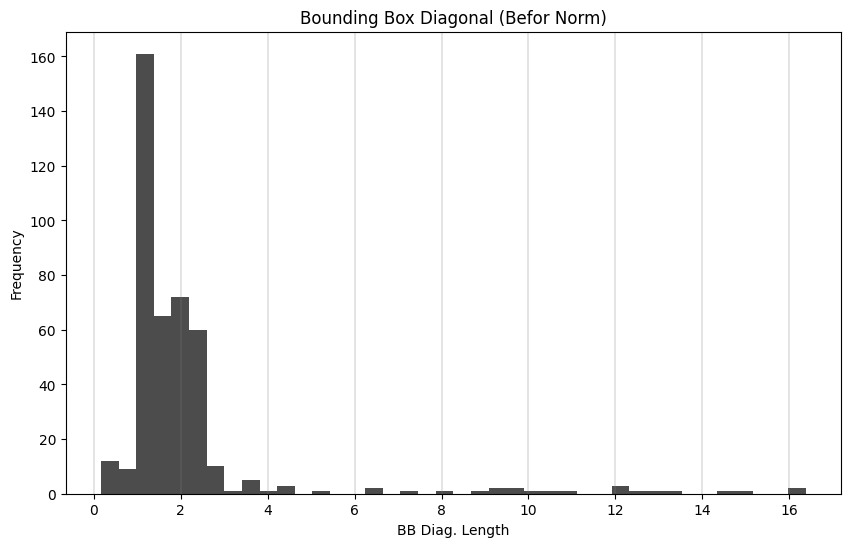

+ 14 more


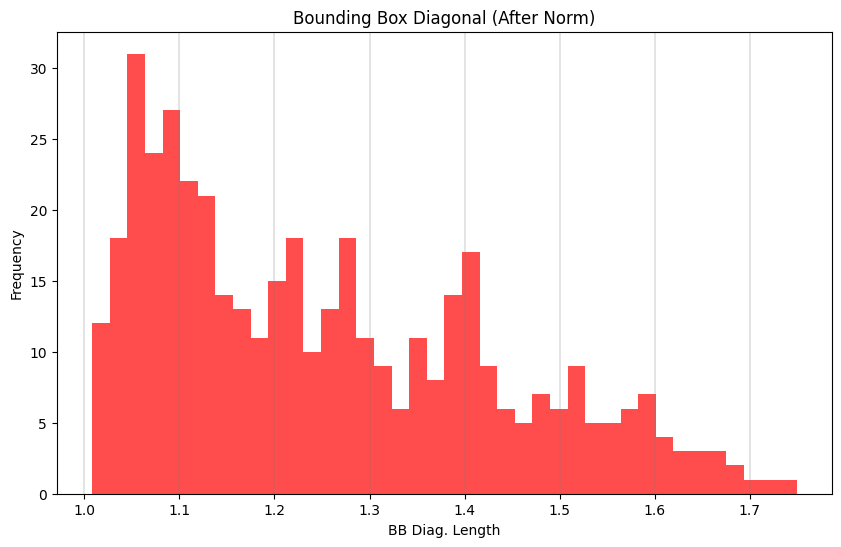

+ 10 more


In [15]:
import pandas as pd
import numpy as np
import trimesh
import os
import matplotlib.pyplot as plt

def compute_bounding_box_diagonal_from_mesh(mesh):
    """
    Compute the diagonal of the bounding box directly from a mesh object.
    """
    min_bound = mesh.bounds[0]
    max_bound = mesh.bounds[1]
    diagonal = np.linalg.norm(max_bound - min_bound)
    return diagonal

def load_and_compute_bounding_box(mesh_file_path):
    """
    Load the mesh from file and compute its bounding box diagonal.
    """
    try:
        mesh = trimesh.load(mesh_file_path)
        return compute_bounding_box_diagonal_from_mesh(mesh)
    except Exception as e:
        print(f"Error loading {mesh_file_path}: {e}")
        return None

def plot_single_histogram(data, title, color, xlabel="BB Diag. Length", ylabel="Frequency", bins=40):
    """
    Helper function to plot a single histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, color='grey', linestyle='-', linewidth=0.3)
    plt.gca().yaxis.grid(False)
    plt.show()

# Paths to the remeshed and normalized datasets
REMESHED_DATA_PATH = 'datasets/dataset_snippet_medium_remeshed_cleaned'
NORMALIZED_DATA_PATH = 'datasets/dataset_snippet_medium_normalized'

# List to store bounding box diagonals
remeshed_bounding_box_diagonals = []
normalized_bounding_box_diagonals = []

remeshed_outliers = 0
normalized_outliers = 0

# Load remeshed shapes and compute their bounding box diagonals
for root, dirs, files in os.walk(REMESHED_DATA_PATH):
    for file in files:
        if file.endswith('.obj'):
            file_path = os.path.join(root, file)
            diagonal = load_and_compute_bounding_box(file_path)
            if diagonal and diagonal <= 20:
                remeshed_bounding_box_diagonals.append(diagonal)
            else:
                remeshed_outliers += 1

# Load normalized shapes and compute their bounding box diagonals
for root, dirs, files in os.walk(NORMALIZED_DATA_PATH):
    for file in files:
        if file.endswith('.obj'):
            file_path = os.path.join(root, file)
            diagonal = load_and_compute_bounding_box(file_path)
            if diagonal and diagonal<=1.75:
                normalized_bounding_box_diagonals.append(diagonal)
            else:
                normalized_outliers += 1


# Save the bounding box diagonals to CSV
remeshed_df = pd.DataFrame(remeshed_bounding_box_diagonals, columns=['Bounding Box Diagonal'])
normalized_df = pd.DataFrame(normalized_bounding_box_diagonals, columns=['Bounding Box Diagonal'])

remeshed_df.to_csv('outputs/data/remeshed_bounding_box_diagonals.csv', index=False)
normalized_df.to_csv('outputs/data/normalized_bounding_box_diagonals.csv', index=False)

# Plot histograms for bounding box sizes before and after normalization
plot_single_histogram(remeshed_bounding_box_diagonals, "Bounding Box Diagonal (Befor Norm)", color='black')
print(f"+ {remeshed_outliers} more")

plot_single_histogram(normalized_bounding_box_diagonals, "Bounding Box Diagonal (After Norm)", color='red')
print(f"+ {normalized_outliers} more")

# Mesh Centroid plots

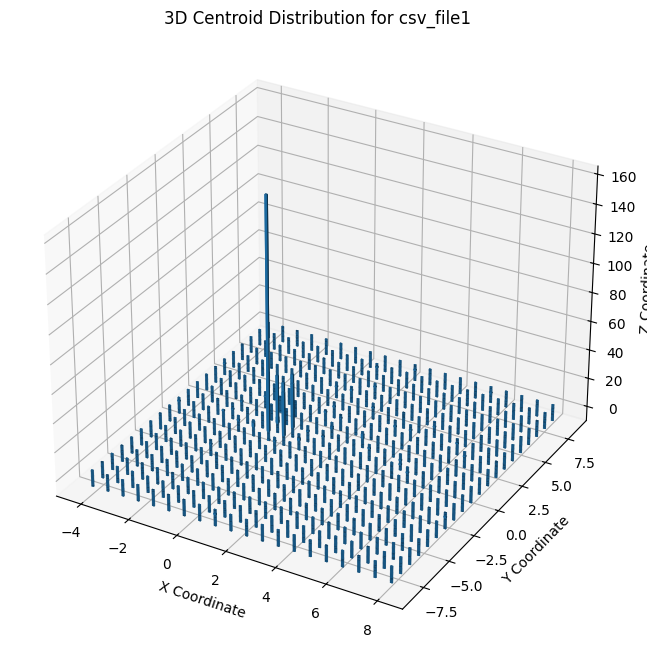

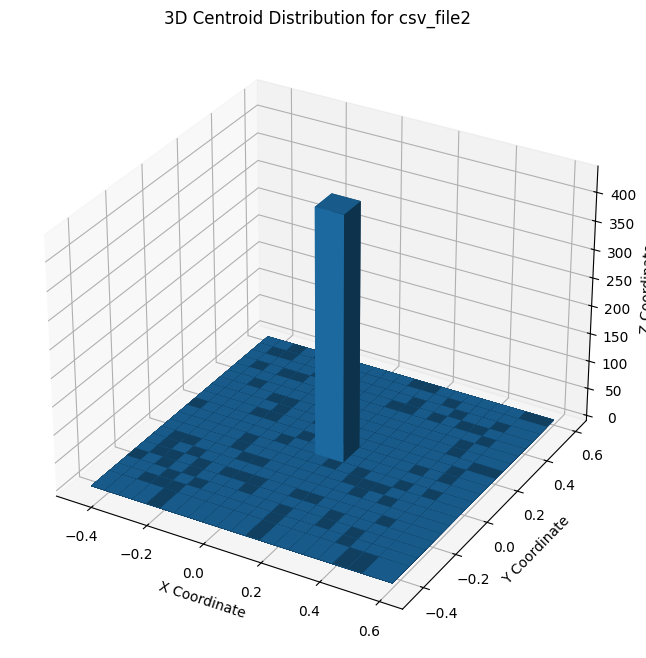

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to load the CSV file and extract the centroid coordinates
def load_and_extract_centroids(csv_file):
    df = pd.read_csv(csv_file)
    # Simplifying centroid values to two decimal places and converting string to list
    df['centroid'] = df['centroid'].apply(lambda x: [round(coord, 2) for coord in eval(x)])
    centroids = np.array(df['centroid'].tolist())
    
    # Filter out rows where any coordinate in the centroid is greater than 30
    filtered_centroids = centroids[np.all(centroids <= 10, axis=1)]
    
    return filtered_centroids

# Function to plot a 3D histogram for the centroid distribution
def plot_3d_histogram(centroids, file_name, bins=20):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Split the centroids into x, y, and z components
    x = centroids[:, 0]
    y = centroids[:, 1]
    z = centroids[:, 2]
    
    # Create a 3D histogram
    hist, edges = np.histogramdd((x, y, z), bins=bins)
    
    # Define positions for the bars
    xpos, ypos, zpos = np.meshgrid(edges[0][:-1] + 0.05, edges[1][:-1] + 0.05, edges[2][:-1] + 0.05, indexing="ij")
    
    # Plot the bars in 3D space
    ax.bar3d(xpos.ravel(), ypos.ravel(), zpos.ravel(), 0.1, 0.1, hist.ravel(), shade=True)

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(f'3D Centroid Distribution for {file_name}')
    
    plt.show()

# Example usage with one of the CSV files
# Replace 'csv_file1.csv' with your actual file paths
centroids1 = load_and_extract_centroids('outputs/shapes_data_remeshed_cleaned.csv')
plot_3d_histogram(centroids1, 'csv_file1')

centroids2 = load_and_extract_centroids('outputs/shapes_data_normalized.csv')
plot_3d_histogram(centroids2, 'csv_file2')


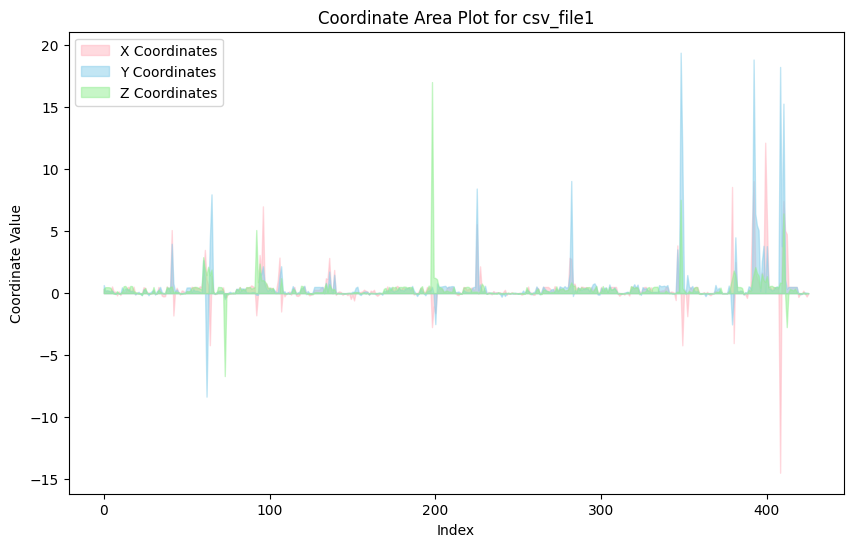

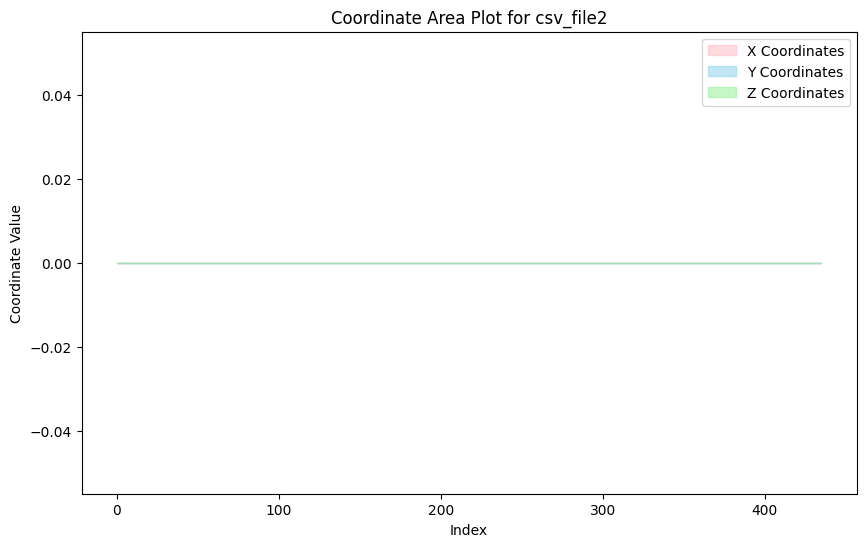

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to load the CSV file and extract the centroid coordinates
def load_and_extract_centroids(csv_file):
    df = pd.read_csv(csv_file)
    # Simplifying centroid values to two decimal places and converting string to list
    df['centroid'] = df['centroid'].apply(lambda x: [round(coord, 2) for coord in eval(x)])
    centroids = np.array(df['centroid'].tolist())
    
    # Filter out rows where any coordinate in the centroid is greater than 30
    filtered_centroids = centroids[np.all((centroids >= -20) & (centroids <= 20), axis=1)]
    
    return filtered_centroids

# Function to create the fill-between plots for x, y, and z coordinates
def plot_fill_between_areas(centroids, file_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Split the centroids into x, y, and z components
    x_coords = centroids[:, 0]
    y_coords = centroids[:, 1]
    z_coords = centroids[:, 2]
    
    # Get the index positions for plotting (assuming we use 12 points or the number of points available)
    index = np.arange(len(x_coords))

    # Plot the fill-between areas for x, y, and z coordinates
    plt.fill_between(index, x_coords, color="lightpink", alpha=0.5, label='X Coordinates')
    plt.fill_between(index, y_coords, color="skyblue", alpha=0.5, label='Y Coordinates')
    plt.fill_between(index, z_coords, color="lightgreen", alpha=0.5, label='Z Coordinates')

    plt.xlabel('Index')
    plt.ylabel('Coordinate Value')
    plt.title(f'Coordinate Area Plot for {file_name}')
    
    plt.legend()
    plt.show()

# Replace 'csv_file1.csv' with your actual file paths
centroids1 = load_and_extract_centroids('outputs/shapes_data_remeshed_cleaned.csv')
plot_fill_between_areas(centroids1, 'csv_file1')

centroids2 = load_and_extract_centroids('outputs/shapes_data_normalized.csv')
plot_fill_between_areas(centroids2, 'csv_file2')


In [204]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go


# Function to load the CSV file and extract the centroid coordinates
def load_and_extract_centroids(csv_file):
    df = pd.read_csv(csv_file)
    # Simplifying centroid values to two decimal places and converting string to list
    df['centroid'] = df['centroid'].apply(lambda x: [round(coord, 2) for coord in eval(x)])
    centroids = np.array(df['centroid'].tolist())
    
    # Filter out rows where any coordinate in the centroid is outside the range of -30 to 30
    filtered_centroids = centroids[np.all((centroids >= -30) & (centroids <= 30), axis=1)]
    
    if len(filtered_centroids) > 50:
        sampled_centroids = filtered_centroids[np.random.choice(len(filtered_centroids), 50, replace=False)]
    else:
        sampled_centroids = filtered_centroids
    
    return sampled_centroids

# Function to create a spider plot for each centroid
def create_combined_spider_plot(centroids, file_name):
    categories = ['X Coordinate', 'Y Coordinate', 'Z Coordinate']
    
    fig = go.Figure()
    
    # Define a list of colors to use for the plots
    colors = ['rgba(255, 99, 71, 0.4)', 'rgba(54, 162, 235, 0.4)', 'rgba(75, 192, 192, 0.4)',
              'rgba(153, 102, 255, 0.4)', 'rgba(255, 159, 64, 0.4)', 'rgba(255, 206, 86, 0.4)']


    # Loop through each centroid and add it to the spider plot
    for i, centroid in enumerate(centroids):
        fig.add_trace(go.Scatterpolar(
            r=np.append(centroid, centroid[0]),  # Closing the loop for the radar chart
            theta=categories + [categories[0]],  # Closing the loop on the theta axis
            fill='toself',
            fillcolor=colors[i % len(colors)],  # Cycle through colors for each centroid
            opacity=0.5,  # Set transparency level
            name=f'Centroid {i+1}'
            
        ))

    # Update layout to make it look good
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[centroids.min(), centroids.max()]  # Set range based on data
            )
        ),
        showlegend=True,  # You can toggle legend visibility as needed
        title=f'Spider Plot for {file_name}',
        width=800,
        height=600
    )

    # Show the plot
    fig.show()
    
# Replace 'csv_file1.csv' with your actual file paths
centroids1 = load_and_extract_centroids('outputs/shapes_data_remeshed_cleaned.csv')
create_combined_spider_plot(centroids1, 'csv_file1')

centroids2 = load_and_extract_centroids('outputs/shapes_data_normalized.csv')
create_combined_spider_plot(centroids2, 'csv_file2')



# Voxelize mesh

0.02829000000000001


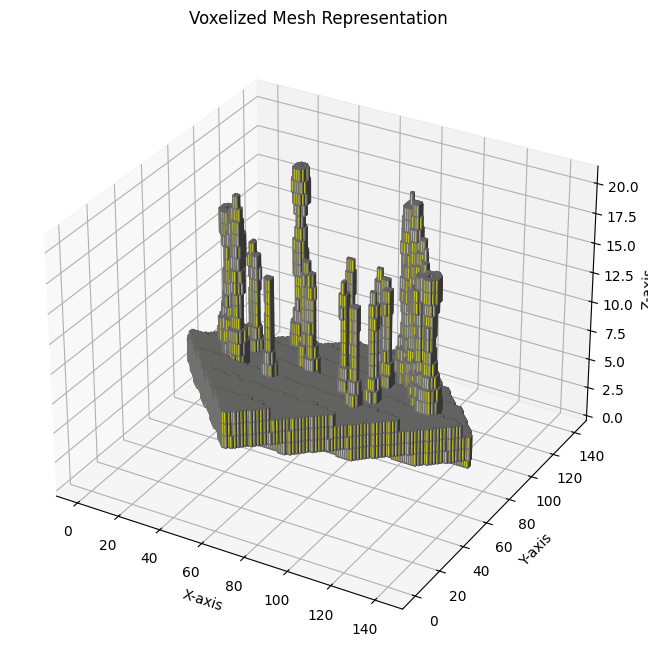

<trimesh.VoxelGrid(142, 141, 21)>

In [29]:
import matplotlib.pyplot as plt
import trimesh
import numpy as np

def plot_voxelized_mesh(mesh, pitch=0.005):
    """
    Voxelizes the input mesh and plots the voxelized mesh as 3D voxels.
    
    Parameters:
        mesh (trimesh.Trimesh): The input mesh to voxelize.
        pitch (float): The size of each voxel (default is 0.05).
        
    Returns:
        voxelized_mesh: The voxelized mesh.
    """
    # Voxelize the mesh
    voxelized_mesh = mesh.voxelized(pitch)
    print(voxelized_mesh.volume)
    # Get the filled voxel grid (boolean grid)
    filled_voxels = voxelized_mesh.matrix

    # Get the voxel grid shape
    shape = filled_voxels.shape

    # Create a 3D grid for plotting
    x, y, z = np.indices((shape[0] + 1, shape[1] + 1, shape[2] + 1))

    # Plot the voxel grid
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot voxels where the voxel grid is filled (True)
    ax.voxels(x, y, z, filled_voxels, facecolors='yellow', edgecolors='gray')

    # Label and set plot
    ax.set_title('Voxelized Mesh Representation')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.show()

    return voxelized_mesh

# Example usage:

# Load the mesh
mesh = trimesh.load('datasets/dataset_snippet_medium_normalized/Chess/m1595.obj')
plot_voxelized_mesh(mesh, pitch=0.01)



# Test Global Descriptors

### Elongation

In [11]:
import trimesh
import numpy as np

def compute_elongation(mesh):
    extents = mesh.bounding_box_oriented.extents
    sorted_extents = np.sort(extents) 
    print(f"Sorted extends: {sorted_extents}")

    elongation = sorted_extents[-1] / sorted_extents[-2]

    return elongation

round_object = 'datasets/dataset_snippet_medium_normalized/Drum/D00115.obj'
long_object = 'datasets/dataset_snippet_medium_normalized/Sword/D00992.obj'

round_object_mesh = trimesh.load(round_object)
long_object_mesh = trimesh.load(long_object)

print("Round object")
print(f"Elongation: {compute_elongation(round_object_mesh)}")
print()
print("Long object")
print(f"Elongation: {compute_elongation(long_object_mesh)}")

Round object
Sorted extends: [0.60027802 0.60354348 0.825552  ]
Elongation: 1.367841807312158

Long object
Sorted extends: [0.04020034 0.31897965 1.01168248]
Elongation: 3.1716207293415324


### Rectangularity

In [16]:
import trimesh

def compute_voxel_volume(mesh, pitch=0.01):
    voxelized = mesh.voxelized(pitch)
    total_volume = voxelized.volume
    return total_volume

def compute_rectangularity(mesh, volume):
    obb = mesh.bounding_box_oriented        
    rectangularity = volume / obb.volume  
    
    print(f"Mesh volume: {volume}  |  OBB volume: {obb.volume}")
    return rectangularity



not_rectangular_object = 'datasets/dataset_snippet_medium_normalized/Biplane/m1127.obj'
rectangular_object = 'datasets/dataset_snippet_medium_normalized/Door/D01141.obj'

not_rectangular_object_mesh = trimesh.load(not_rectangular_object)
rectangular_object_mesh = trimesh.load(rectangular_object)

not_rectangular_object_volume = compute_voxel_volume(not_rectangular_object_mesh)
rectangular_object_volume = compute_voxel_volume(rectangular_object_mesh)

print("Not rectangular object")
print(f"Rectangularity: {compute_rectangularity(not_rectangular_object_mesh, not_rectangular_object_volume)}")
print()
print("Rectangular object")
print(f"Rectangularity: {compute_rectangularity(rectangular_object_mesh, rectangular_object_volume)}")

Not rectangular object
Mesh volume: 0.010368000000000004  |  OBB volume: 0.1808983192293893
Rectangularity: 0.0573139653489693

Rectangular object
Mesh volume: 0.012352000000000005  |  OBB volume: 0.03964519811876834
Rectangularity: 0.31156358363996856


### Compactness

In [31]:
import trimesh

def compute_surface_area(mesh):
    return mesh.area

def compute_voxel_volume(mesh, pitch=0.01):
    voxelized = mesh.voxelized(pitch)
    total_volume = voxelized.volume
    return total_volume

def compute_compactness(mesh, volume):
    area = compute_surface_area(mesh)
    compactness = (area ** 3) / (36 * np.pi * (volume ** 2))
    return compactness


not_compact_object = 'datasets/dataset_snippet_medium_normalized/Sign/m1680.obj'
compact_object = 'datasets/dataset_snippet_medium_normalized/Drum/D00063.obj'

not_compact_object_mesh = trimesh.load(not_compact_object)
compact_object_mesh = trimesh.load(compact_object)

not_compact_object_object_volume = compute_voxel_volume(not_compact_object_mesh)
compact_object_volume = compute_voxel_volume(compact_object_mesh)

print("Not compact object")
print(f"Compactness: {compute_compactness(not_compact_object_mesh, not_compact_object_object_volume)}")
print()
print("Compact object")
print(f"Compactness: {compute_compactness(compact_object_mesh, compact_object_volume)}")

Not compact object
Compactness: 38.34224864162249

Compact object
Compactness: 444.8842480505854


### Diameter

In [177]:
import trimesh
import random

def get_diameter(mesh, method="fast"):
    convex_hull = mesh.convex_hull
    max_dist = 0
    vertices = list(convex_hull.vertices)
    print(f"Vertices of convex hull: {len(vertices)}")
    
    if method == "fast": 
        """SAMPLE 200 VERTICES"""
    
        if len(vertices) > 200:
            vertices = random.sample(vertices, 1000)
    
    if method == "slow":
        pass
    
    for i in range(len(vertices)):
        for j in range(i, len(vertices)):
            dist = np.linalg.norm(vertices[i] - vertices[j])
            if dist > max_dist:
                max_dist = dist
    
    return max_dist


short_diameter_object = 'datasets/dataset_snippet_medium_normalized/PlantIndoors/D00087.obj'
long_diameter_object = 'datasets/dataset_snippet_medium_normalized/Musical_Instrument/m646.obj'

short_diamete_object_mesh = trimesh.load(short_diameter_object)
long_diameter_object_mesh = trimesh.load(long_diameter_object)

print("Short diameter object")
print(f"Diameter: {get_diameter(short_diamete_object_mesh)}")
print()
print("Long diameter object")
print(f"Diameter: {get_diameter(long_diameter_object_mesh)}")

Short diameter object
Vertices of convex hull: 185
Diameter: 1.055804258777098

Long diameter object
Vertices of convex hull: 132
Diameter: 1.2183989532656814


### Convexity

In [180]:
import trimesh

def compute_voxel_volume(mesh, pitch=0.01):
    voxelized = mesh.voxelized(pitch)
    total_volume = voxelized.volume
    return total_volume

def compute_convexity(mesh, volume):
    """
    Computes the convexity of the mesh.
    Convexity is defined as the ratio of the mesh volume to the volume of its convex hull.
    
    Parameters:
        mesh (trimesh.Trimesh): The input mesh.
        
    Returns:
        float: The convexity of the mesh.
        
    Raises:
        ValueError: If the mesh is not watertight (no volume).
    """
    convex_hull = mesh.convex_hull
    convex_hull_volume = compute_voxel_volume(convex_hull)
    convexity = min((volume / convex_hull_volume), 1.0)
    convexity = max(0, convexity)
    return convexity


not_convex_object = 'datasets/dataset_snippet_medium_normalized/Sign/m1680.obj'
convex_object = 'datasets/dataset_snippet_medium_normalized/Drum/D00063.obj'

not_convex_object_mesh = trimesh.load(not_convex_object)
convex_object_mesh = trimesh.load(convex_object)

not_convex_object_volume = compute_voxel_volume(not_convex_object_mesh)
convex_object_volume = compute_voxel_volume(convex_object_mesh)

print("Not convex object")
print(f"Convexity: {compute_convexity(not_convex_object_mesh, not_convex_object_volume)}")
print()
print("Convex object")
print(f"Convexity: {compute_convexity(convex_object_mesh, convex_object_volume)}")

Not convex object
Convexity: 0.5096685082872928

Convex object
Convexity: 1.0


### Eccentricity

In [191]:
import trimesh
import sys

def compute_eccentricity(mesh):
    """
    Computes the eccentricity of the mesh.
    Eccentricity is defined as the ratio of the largest to smallest eigenvalues of the covariance matrix of the vertices.
    
    Parameters:
        mesh (trimesh.Trimesh): The input mesh.
        
    Returns:
        float: The eccentricity of the mesh.
    """
    eigenvalues, _ = get_eigen(mesh)
    # Sort the eigenvalues in ascending order
    eigenvalues = np.sort(np.abs(eigenvalues))
    
    lambda_3  = eigenvalues[0]
    lambda_1  = eigenvalues[-1]
    
    # Handle zero eigenvalues to prevent division by zero
    if lambda_3 == 0:
        lambda_3 = sys.float_info.min  # Smallest positive float
    
    eccentricity = lambda_1 / lambda_3
    return eccentricity


def get_eigen(mesh):
    """
    Computes the eigenvalues and eigenvectors of the covariance matrix of the mesh vertices.
    
    Parameters:
        mesh (trimesh.Trimesh): The input mesh.
        
    Returns:
        tuple: (eigenvalues, eigenvectors)
    """
    vertices = mesh.vertices
    # Compute covariance matrix; set rowvar=False because each row is an observation (vertex)
    covariance_matrix = np.cov(vertices, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    return eigenvalues, eigenvectors


not_eccentric_object = 'datasets/dataset_snippet_medium_normalized/Tool/m1111.obj'
eccentric_object = 'datasets/dataset_snippet_medium_normalized/Drum/D00709.obj'

not_eccentric_object_mesh = trimesh.load(not_eccentric_object)
eccentric_object_mesh = trimesh.load(eccentric_object)

print("Not eccentric object")
print(f"Eccentricity: {compute_eccentricity(not_eccentric_object_mesh)}")
print()
print("Eccentric object")
print(f"Eccentricity: {compute_eccentricity(eccentric_object_mesh)}")

Not eccentric object
Eccentricity: 126.14757738890484

Eccentric object
Eccentricity: 4.93031844216137


### Sphericity

In [198]:
import trimesh

def compute_voxel_volume(mesh, pitch=0.01):
    voxelized = mesh.voxelized(pitch)
    
    total_volume = voxelized.volume
    return total_volume

def compute_compactness(mesh, volume):
    area = compute_surface_area(mesh)
    compactness = (area ** 3) / (36 * np.pi * (volume ** 2))
    return compactness


def compute_sphericity(compactness):
    sphericity = min((1/compactness), 1.0)
    sphericity = max(0, sphericity)

    return  sphericity


not_spherical_object = 'datasets/dataset_snippet_medium_normalized/AircraftBuoyant/m1347.obj'
spherical_object = 'datasets/dataset_snippet_medium_normalized/AircraftBuoyant/m1351.obj'

not_spherical_object_mesh = trimesh.load(not_spherical_object)
spherical_object_mesh = trimesh.load(spherical_object)

not_spherical_object_volume = compute_voxel_volume(not_spherical_object_mesh)
spherical_object_volume = compute_voxel_volume(spherical_object_mesh)

not_spherical_object_compactness = compute_compactness(not_spherical_object_mesh, not_spherical_object_volume)
spherical_object_compactness = compute_compactness(spherical_object_mesh, spherical_object_volume)

print("Not spherical object")
print(f"Sphericity: {compute_sphericity(not_spherical_object_compactness)}")
print()
print("Spherical object")
print(f"Sphericity: {compute_sphericity(spherical_object_compactness)}")

Not spherical object
Sphericity: 0.015501944644075172

Spherical object
Sphericity: 0.023035551928644905


# Evaluation


## Precision

In [5]:
import pandas as pd
import plotly.express as px

# Load data
data = pd.read_csv('outputs/eval/combined_recalls.csv')  # Make sure your CSV includes columns for class, regular_recall, and enhanced_recall

# Create the interactive scatter plot
fig = px.scatter(
    data,
    x='mean_recall_regular',
    y='mean_recall_enhanced',
    text='obj_class',  # Display class names on hover
    title='Interactive Scatter Plot of Regular vs. Enhanced Recall by Class'
)

# Add a line y=x for reference
fig.add_shape(
    type="line",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(dash="dash", color="gray")
)

fig.update_traces(marker=dict(size=8, color='blue'), textposition='top center')
fig.update_layout(xaxis_title="Regular Recall", yaxis_title="Enhanced Recall")
fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load data
data = pd.read_csv('outputs/eval/combined_recalls.csv')

# Find top 10 and bottom 10 for both regular and enhanced recall
top_10_regular = data.nlargest(10, 'mean_recall_regular')
bottom_10_regular = data.nsmallest(10, 'mean_recall_regular')
top_10_enhanced = data.nlargest(10, 'mean_recall_enhanced')
bottom_10_enhanced = data.nsmallest(10, 'mean_recall_enhanced')

# Combine data for visualization
combined_data = pd.concat([top_10_regular, bottom_10_regular, top_10_enhanced, bottom_10_enhanced])
combined_data['category'] = (
    ['Top 10 Regular'] * 10 + ['Bottom 10 Regular'] * 10 +
    ['Top 10 Enhanced'] * 10 + ['Bottom 10 Enhanced'] * 10
)

fig = px.bar(
    combined_data,
    x='obj_class',
    y='mean_recall_regular',
    color='category',
    title='High and Low Recall Classes for Regular and Enhanced Searches',
    barmode='group',
    text='mean_recall_regular'
)

fig.update_layout(xaxis_title="Class", yaxis_title="Recall", xaxis={'categoryorder': 'total descending'})
fig.show()


In [19]:
import pandas as pd
import plotly.express as px

# Load data and calculate recall change
data = pd.read_csv('outputs/eval/combined_recalls.csv')
data['recall_change'] = data['mean_recall_enhanced'] - data['mean_recall_regular']

# Create histogram
fig = px.histogram(
    data,
    x='recall_change',
    nbins=20,
    title='Histogram of Recall Changes (Enhanced - Regular)',
    color_discrete_sequence=['indigo']
)

fig.update_layout(xaxis_title="Recall Change", yaxis_title="Frequency")
fig.show()


In [17]:
import pandas as pd
import plotly.express as px

# Load data and calculate change in recall
data = pd.read_csv('outputs/eval/combined_recalls.csv')
data['recall_change'] = data['mean_recall_enhanced'] - data['mean_recall_regular']

# Find top 10 classes with greatest positive and negative change
top_10_positive_change = data.nlargest(5, 'recall_change')
top_10_negative_change = data.nsmallest(5, 'recall_change').sort_values(by=['recall_change'], ascending=False)
change_data = pd.concat([top_10_positive_change, top_10_negative_change]).round(2)

fig = px.bar(
    change_data,
    x='obj_class',
    y='recall_change',
    color='recall_change',
    color_continuous_scale='RdYlGn',
    title='Top 10 Increases and Decreases in Recall',
    text='recall_change'
)

fig.update_layout(xaxis_title="Class", yaxis_title="Change in Recall")
fig.show()


In [23]:
data = pd.read_csv('outputs/eval/combined_recalls.csv')
mean_regular = data['mean_recall_regular'].mean()
mean_enhanced = data['mean_recall_enhanced'].mean()

mean_regular, mean_enhanced

(0.41565217391304354, 0.6352173913043478)